## Solar Orbiter data for 2022 Sep CME event

use environment helio3




In [6]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
from datetime import timezone
import pytz


import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle

import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import astrospice
import spiceypy

import warnings
warnings.filterwarnings('ignore')


import heliosat

#on mac
sys.path.append('/Users/chris/python/heliocats')

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


plt.rcParams["figure.figsize"] = (15,5)


from astropy.constants import au
#define AU in km
AU=au.value/1e3
print(heliosat.__version__)
print(spiceypy.__version__)

import cdflib

print('done')

0.6.2
5.1.2
done



### read SolO/SWA plasma data (science level 2) - use case 2022 Sep 5 CME

done
{'Item_Size': 4, 'Data_Type': 'CDF_CHAR', 'Num_Items': 1, 'Data': 'km/s'}
{'Item_Size': 15, 'Data_Type': 'CDF_CHAR', 'Num_Items': 1, 'Data': 'particles cm^-3'}
{'Item_Size': 2, 'Data_Type': 'CDF_CHAR', 'Num_Items': 1, 'Data': 'eV'}


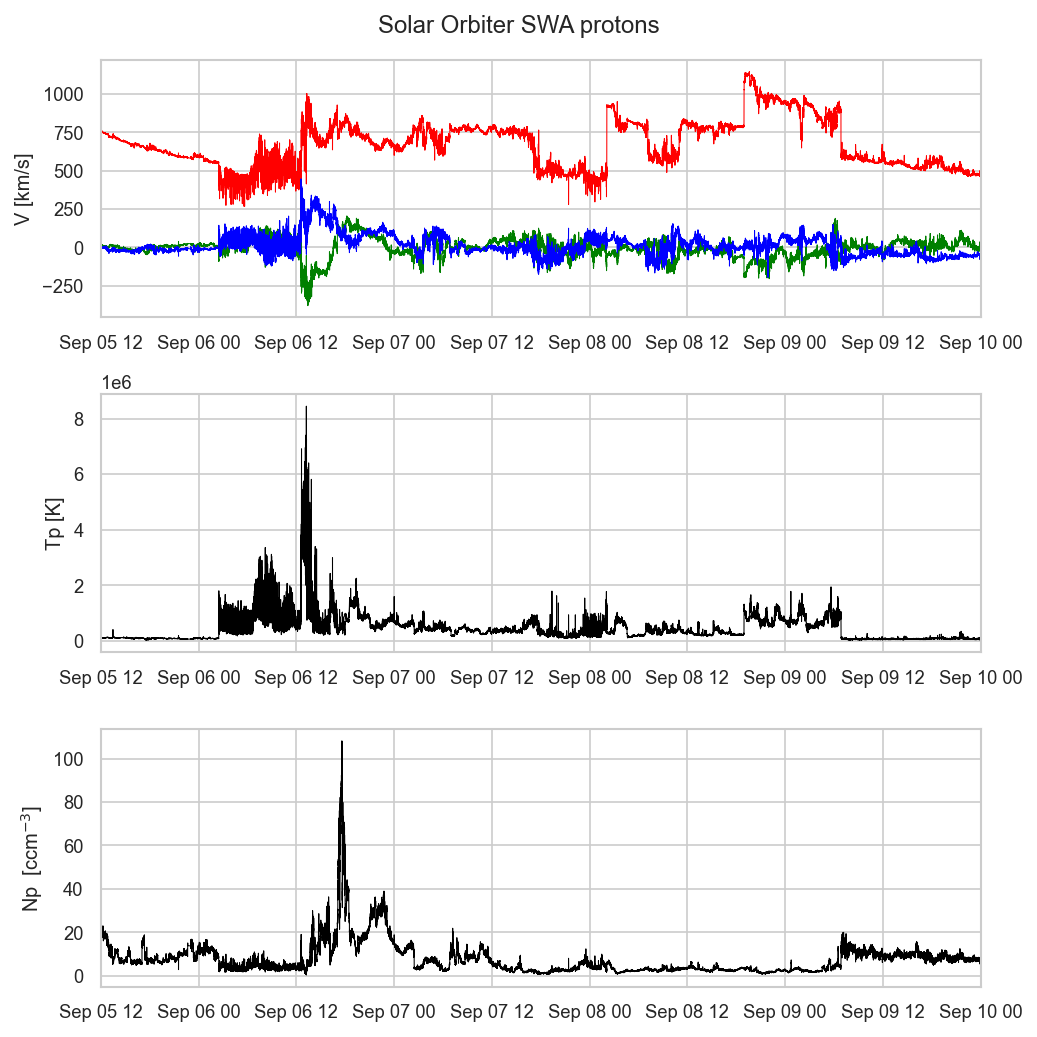

In [104]:
sns.set_style('whitegrid')
sns.set_context('paper')

#locally on Macbook
ll_path = "../data/solo_swa_2022sep"

files = os.listdir(ll_path)
files.sort()
llfiles = [os.path.join(ll_path, f) for f in files]
#print(llfiles)

timep=np.zeros(0,dtype=[('time',object)])
den=np.zeros(0)
temp=np.zeros(0)
vr=np.zeros(0)
vt=np.zeros(0)
vn=np.zeros(0)


for i in np.arange(0,len(llfiles)):
    p1 = cdflib.CDF(llfiles[i])
    #p1.cdf_info()

    den1=p1.varget('N')
    speed1=p1.varget('V_RTN')
    temp1=p1.varget('T')

    vr1=speed1[:,0]
    vt1=speed1[:,1]
    vn1=speed1[:,2]
    
    vr=np.append(vr1,vr)
    vt=np.append(vt1,vt)
    vn=np.append(vn1,vn)
    
    
    temp=np.append(temp1,temp)
    den=np.append(den1,den)

    
    time1=p1.varget('EPOCH')
    t1=parse_time(cdflib.cdfastropy.convert_to_astropy(time1, format=None)).datetime
    timep=np.append(timep,t1)
    #print(time1)


temp=temp*(1.602176634*1e-19)/(1.38064852*1e-23) # from ev to K 



plt.figure(1,figsize=(7,7),dpi=150)

ax1 = plt.subplot(311) 

plt.suptitle('Solar Orbiter SWA protons')
plt.plot(timep, vr, 'r',lw=0.5)
plt.plot(timep, vt, 'g',lw=0.5)
plt.plot(timep, vn, 'b',lw=0.5)
plt.ylabel('V [km/s]')

ax2 = plt.subplot(312) 
plt.plot(timep, temp, 'k', lw=0.5)
plt.ylabel('Tp [K]')

ax3 = plt.subplot(313) 
plt.plot(timep, den, 'k', lw=0.5)
plt.ylabel(r'Np  [ccm$^{-3}$]')


plotstart=datetime.datetime(2022,9,5,12)
plotend=datetime.datetime(2022,9,10,0)
ax1.set_xlim(plotstart,plotend)
ax2.set_xlim(plotstart,plotend)
ax3.set_xlim(plotstart,plotend)

date_form = DateFormatter("%h %d %H")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)
ax3.xaxis.set_major_formatter(date_form)


plt.tight_layout()

#plt.savefig('lineups/solo_2022_sep_plasma.png')
#plt.savefig('lineups/solo_2022_sep_plasma.pdf')

print('done')

print(p1.attget('UNITS','V_RTN'))
print(p1.attget('UNITS','N'))
print(p1.attget('UNITS','T'))



### read SolO MAG data (low latency) - use case 2022 Sep 5 CME

In [105]:


#locally on Macbook
ll_path = "../data/solo_mag_2022sep"
#ll_path = "/nas/helio/data/SolarOrbiter/MAG/low_latency/"

files = os.listdir(ll_path)
files.sort()
llfiles = [os.path.join(ll_path, f) for f in files]
print(llfiles)

br1=np.zeros(0)
bt1=np.zeros(0)
bn1=np.zeros(0)
time1=np.zeros(0,dtype=[('time',object)])


for i in np.arange(0,len(llfiles)):
    m1 = cdflib.CDF(llfiles[i])
    #print(m1.cdf_info())


    b=m1.varget('B_RTN')
    br=b[:,0]
    bt=b[:,1]
    bn=b[:,2]
    
    br1=np.append(br1,br)
    bt1=np.append(bt1,bt)
    bn1=np.append(bn1,bn)

    time=m1.varget('EPOCH')

    t1=parse_time(cdflib.cdfastropy.convert_to_astropy(time, format=None)).datetime
    time1=np.append(time1,t1)
    
print(m1.attget('UNITS','B_RTN')) 

solo_ll=np.zeros(np.size(time1),dtype=[('time',object),('bx', float),('by', float),\
            ('bz', float),('bt', float),('r', float),('lat', float),('lon', float),\
            ('x', float),('y', float),('z', float),('vx', float),\
            ('vy', float),('vz', float),('vt', float),('tp', float),('np', float) ] )   

solo_ll = solo_ll.view(np.recarray)  

solo_ll.time=time1
solo_ll.bx=br1
solo_ll.by=bt1
solo_ll.bz=bn1
solo_ll.bt=np.sqrt(br1**2+bt1**2+bn1**2)


time1_mat=mdates.date2num(time1)
timep_mat=mdates.date2num(timep)

solo_ll.np=np.interp(time1_mat, timep_mat,den)
solo_ll.tp=np.interp(time1_mat, timep_mat,temp) 
solo_ll.vx=np.interp(time1_mat, timep_mat,vr)
solo_ll.vy=np.interp(time1_mat, timep_mat,vt)
solo_ll.vz=np.interp(time1_mat, timep_mat,vn)
solo_ll.vt=np.sqrt(solo_ll.vx**2+solo_ll.vy**2+solo_ll.vz**2)

#still uses heliopy

spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(solo_ll.time, 'Sun','HEEQ')
solo.change_units(astropy.units.AU)
[solo_r, solo_lat, solo_lon]=hd.cart2sphere(solo.x,solo.y,solo.z)

solo_ll.x=solo.x
solo_ll.y=solo.y
solo_ll.z=solo.z
solo_ll.lon=np.rad2deg(solo_lon) #convert to degree
solo_ll.lat=np.rad2deg(solo_lat)
solo_ll.r=solo_r
     

filename='solo_2022_sep_mag_ll_swa_science.p'
pickle.dump(solo_ll, open(data_path+filename, "wb"))
print('done')

['../data/solo_mag_2022sep/solo_LL02_mag_20220831T000215-20220901T000214_V02C.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220901T000215-20220902T000214_V02C.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220902T000215-20220903T000215_V04I.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220903T000216-20220904T000215_V04I.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220904T000216-20220905T000215_V04I.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220905T000216-20220906T000215_V04I.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220906T000216-20220907T000215_V03C.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220907T000216-20220908T000215_V03C.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220908T000216-20220909T000216_V02C.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220909T000217-20220910T000216_V03C.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220910T000217-20220911T000216_V03C.cdf', '../data/solo_mag_2022sep/solo_LL02_mag_20220911T000217-20220912T000216_V02C.cdf', '..

### plot SolO data 2022 Sep 5 CME

In [106]:
print('load Solar Orbiter low lat RTN and plasma ')
filename='solo_2022_sep_mag_ll_swa_science.p'
solo=pickle.load(open(data_path+filename, "rb" ) )  

load Solar Orbiter low lat RTN and plasma 


In [146]:
### measure
%matplotlib
plt.ion()
hp.plot_insitu_measure(solo, '2022-Sep-5','2022-Sep-10', 'solo', 'results/')


Using matplotlib backend: MacOSX
2022-09-06T07:52Z 57.07305076547266
2022-09-06T15:16Z 6.457677928991075
2022-09-06T13:19Z 546.3828555997065
2022-09-06T14:47Z 10.309885857785119
2022-09-06T14:44Z 0.24955216396854826
2022-09-06T14:58Z 0.6747557008600802
2022-09-06T14:50Z 0.9973239012605526
2022-09-06T14:34Z 1.4420770260551432
2022-09-06T14:29Z 1.7988570052859687
2022-09-06T14:11Z 2.1165378087106763
2022-09-06T13:45Z -45.8805861613921
2022-09-06T12:49Z 2.236279034616912
2022-09-06T12:49Z 2.795885988341974
2022-09-06T12:48Z 3.4312475951913886
2022-09-06T12:37Z 0.5597361794133775
2022-09-06T16:49Z 278.65783642817723
2022-09-06T13:13Z 625.9634498905905


In [140]:
icme_start_time=parse_time('2022-09-06T12:33Z').datetime
mo_start_time=parse_time('2022-09-07T00:36Z').datetime
mo_end_time=parse_time('2022-09-08T04:11Z').datetime


#interface at 2022-09-07T20:55Z

print('SolO times:',icme_start_time, mo_start_time,mo_end_time)


print()
#index of times
icme_start_ind=np.where(solo.time>icme_start_time)[0][0]
mo_start_ind=np.where(solo.time>mo_start_time)[0][0]
mo_end_ind=np.where(solo.time>mo_end_time)[0][0]


print('HEEQ position of SolO r/lat/lon at icme_start_time:',np.round(solo.r[icme_start_ind],3),np.round(solo.lat[icme_start_ind],2),np.round(solo.lon[icme_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_start_time:',np.round(solo.r[mo_start_ind],3),np.round(solo.lat[mo_start_ind],2),np.round(solo.lon[mo_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(solo.r[mo_end_ind],3),np.round(solo.lat[mo_end_ind],2),np.round(solo.lon[mo_end_ind],2))


print('SolO ICME duration hours ', np.round((mo_end_time-icme_start_time).total_seconds()/3600,2))
print('SolO sheath duration hours ', np.round((mo_start_time-icme_start_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((mo_end_time-mo_start_time).total_seconds()/3600,2))
print()


print('SOLO Bmean ICME   ',np.round(np.nanmean(solo.bt[icme_start_ind:mo_end_ind]),2), ' nT')
print('SOLO Bmean sheath ',np.round(np.nanmean(solo.bt[icme_start_ind:mo_start_ind]),2),' nT')
print('SOLO Bmean MO     ',np.round(np.nanmean(solo.bt[mo_start_ind:mo_end_ind]),2),' nT')

print()
print('SOLO Bmax ICME   ',np.round(np.nanmax(solo.bt[icme_start_ind:mo_end_ind]),2), ' nT')
print('SOLO Bmax sheath ',np.round(np.nanmax(solo.bt[icme_start_ind:mo_start_ind]),2),' nT')
print('SOLO Bmax MO     ',np.round(np.nanmax(solo.bt[mo_start_ind:mo_end_ind]),2),' nT')

print()
print()

print('SOLO Vmean ICME   ',np.round(np.nanmean(solo.vt[icme_start_ind:mo_end_ind]),1), 'km/s')
print('SOLO Vmean sheath ',np.round(np.nanmean(solo.vt[icme_start_ind:mo_start_ind]),1),'km/s')
print('SOLO Vmean MO     ',np.round(np.nanmean(solo.vt[mo_start_ind:mo_end_ind]),1),' km/s')


print()
print('SOLO Vmax ICME   ',np.round(np.nanmax(solo.vt[icme_start_ind:mo_end_ind]),1), ' km/s')
print('SOLO Vmax sheath ',np.round(np.nanmax(solo.vt[icme_start_ind:mo_start_ind]),1),' km/s')
print('SOLO Vmax MO     ',np.round(np.nanmax(solo.vt[mo_start_ind:mo_end_ind]),1),' km/s')


print()


print('launch Sep 5 18:24 at 15 Rs')
print('arrival SolO Sep 6 12:33 at 0.689 AU')    

launch_time=datetime.datetime(2022,9,5,18,24,0)
transit_time=icme_start_time-launch_time
transit_dist=solo.r[icme_start_ind]-15*7e5/149.5e6

transit_speed=transit_dist*149.5e6/(transit_time.seconds)


print('Transit time hours', transit_time.seconds/3600)
print('Transit distance AU',transit_dist)

print('Average transit speed',transit_speed)
  


SolO times: 2022-09-06 12:33:00 2022-09-07 00:36:00 2022-09-08 04:11:00

HEEQ position of SolO r/lat/lon at icme_start_time: 0.689 -3.68 149.55
HEEQ position of SolO r/lat/lon at mo_start_time: 0.683 -3.78 149.75
HEEQ position of SolO r/lat/lon at mo_end_time: 0.671 -4.0 150.27
SolO ICME duration hours  39.63
SolO sheath duration hours  12.05
SolO MO duration hours  27.58

SOLO Bmean ICME    30.51  nT
SOLO Bmean sheath  26.05  nT
SOLO Bmean MO      32.44  nT

SOLO Bmax ICME    54.02  nT
SOLO Bmax sheath  54.02  nT
SOLO Bmax MO      52.89  nT


SOLO Vmean ICME    698.5 km/s
SOLO Vmean sheath  760.9 km/s
SOLO Vmean MO      671.5  km/s

SOLO Vmax ICME    1054.7  km/s
SOLO Vmax sheath  1054.7  km/s
SOLO Vmax MO      946.7  km/s

launch Sep 5 18:24 at 15 Rs
arrival SolO Sep 6 12:33 at 0.689 AU
Transit time hours 18.15
Transit distance AU 0.6183898124988069
Average transit speed 1414.8955765009432


done


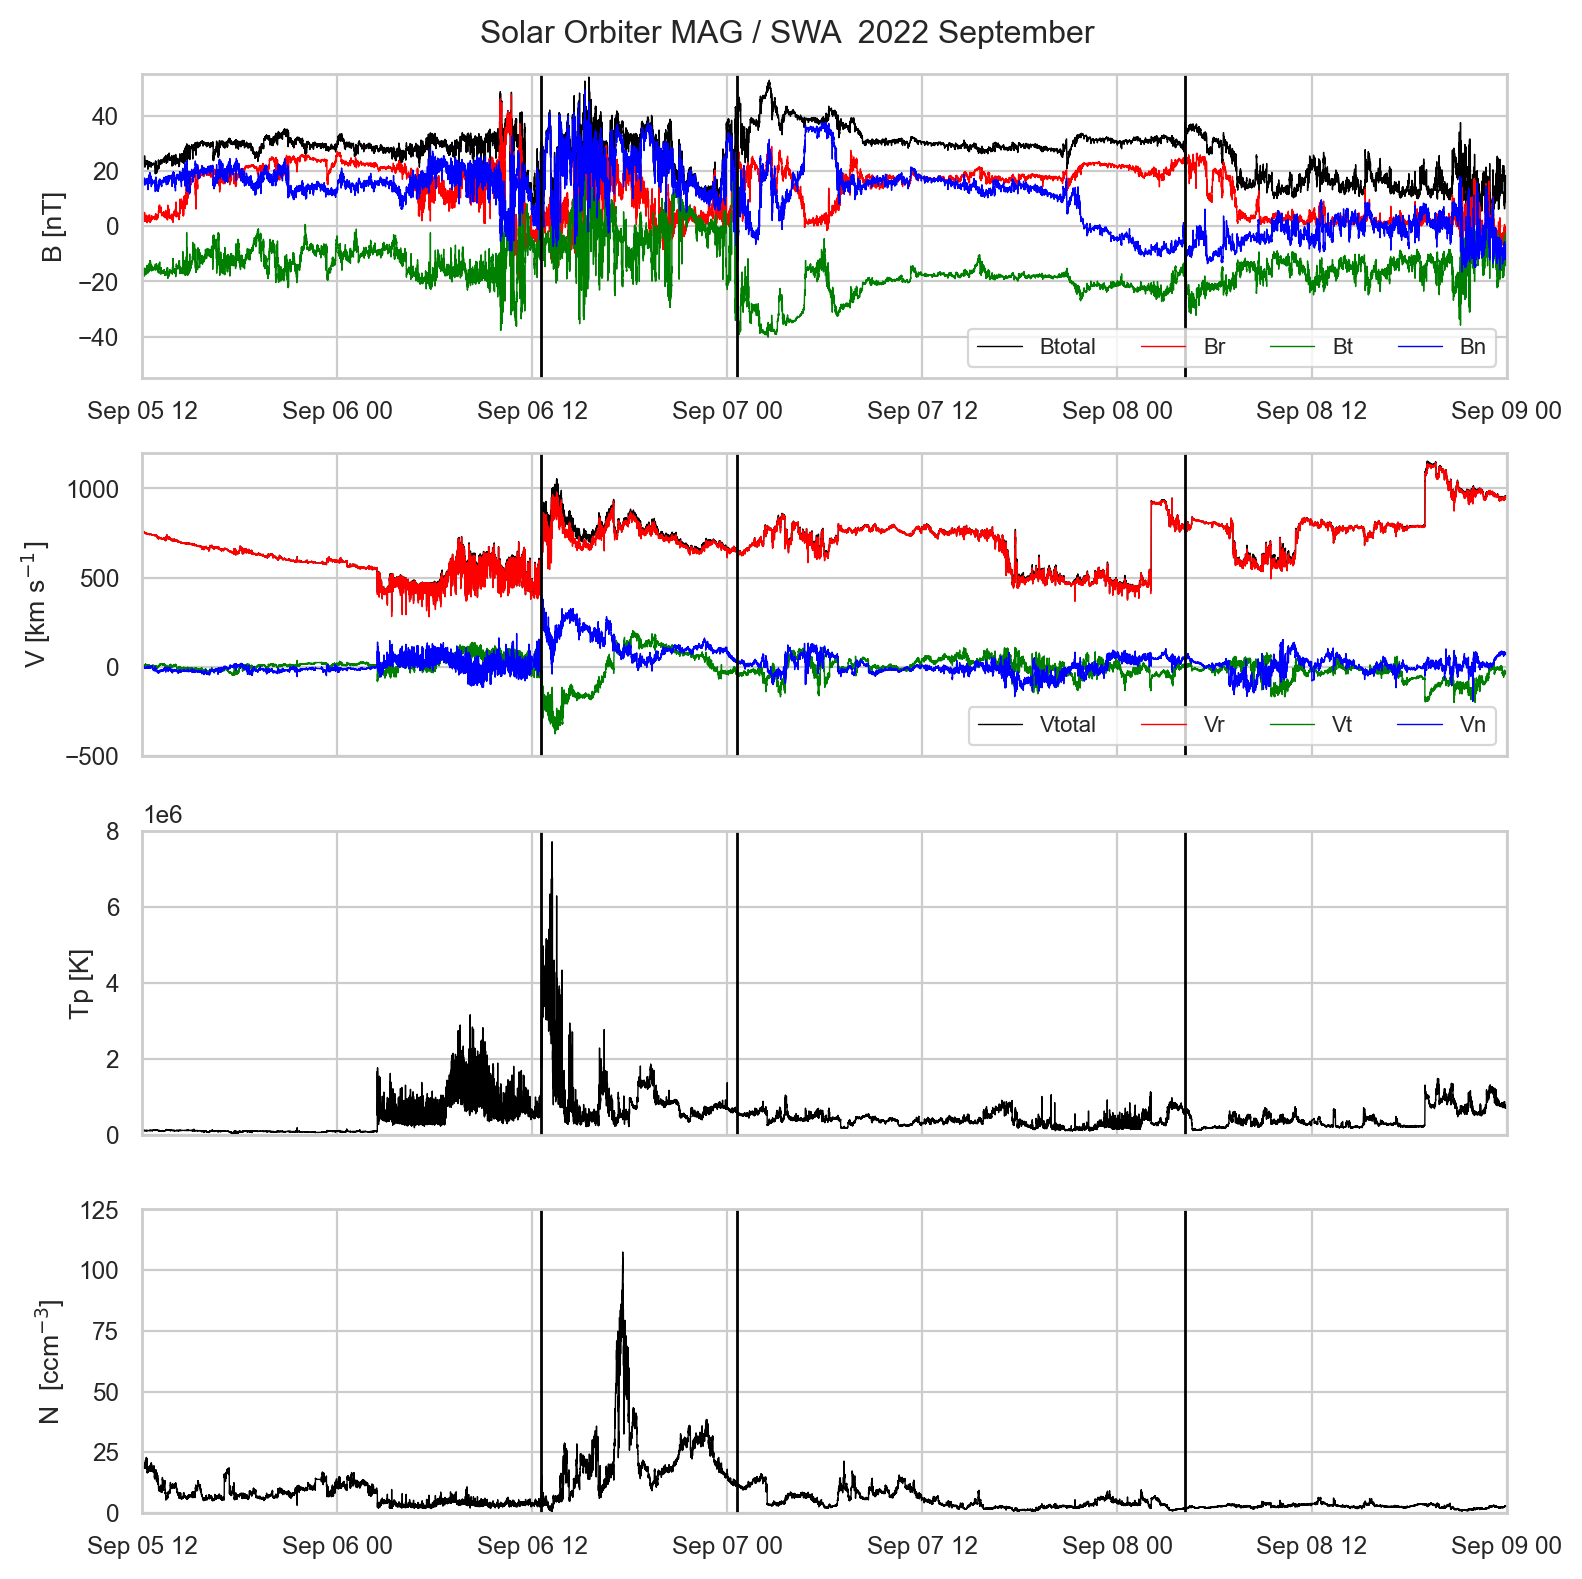

In [131]:
sns.set_style('whitegrid')
sns.set_context('paper')

%matplotlib inline



plt.figure(1,figsize=(8,8),dpi=200)

plt.suptitle('Solar Orbiter MAG / SWA  2022 September ')


ax1 = plt.subplot(411) 

ax1.plot(solo.time,solo.bt,color='black',lw=0.5, label='Btotal')
ax1.plot(solo.time,solo.bx, color='r',lw=0.5,label='Br')
ax1.plot(solo.time,solo.by,color='g',lw=0.5,label='Bt')
ax1.plot(solo.time,solo.bz,color='b',lw=0.5,label='Bn')
plt.ylabel('B [nT]')

ax1.legend(loc=4,ncol=4,fontsize=8)

ax2 = plt.subplot(412) 

plt.plot(solo.time,solo.vt, 'k',lw=0.5,label='Vtotal')
plt.plot(solo.time,solo.vx, 'r',lw=0.5,label='Vr')
plt.plot(solo.time,solo.vy, 'g',lw=0.5,label='Vt')
plt.plot(solo.time,solo.vz, 'b',lw=0.5,label='Vn')
ax2.set_ylabel('V [km s$^{-1}]$')
ax2.legend(loc=4,ncol=4,fontsize=8)
plt.setp(ax2.get_xticklabels(), visible=False)


ax3 = plt.subplot(413) 
plt.plot(solo.time, solo.tp, 'k', lw=0.5)
plt.ylabel('Tp [K]')
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(414) 
plt.plot(solo.time, solo.np, 'k', lw=0.5)
plt.ylabel(r'N  [ccm$^{-3}$]')


plotstart=datetime.datetime(2022,9,5,12)
plotend=datetime.datetime(2022,9,9,0)
ax1.set_xlim(plotstart,plotend)
ax2.set_xlim(plotstart,plotend)
ax3.set_xlim(plotstart,plotend)
ax4.set_xlim(plotstart,plotend)

date_form = DateFormatter("%h %d %H")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)
ax3.xaxis.set_major_formatter(date_form)
ax4.xaxis.set_major_formatter(date_form)


#plot vertical lines
ax1.plot_date([icme_start_time,icme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([mo_start_time,mo_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([mo_end_time,mo_end_time],[-500,500],'-k',linewidth=1)  
ax1.set_ylim(-55,55)


ax2.plot_date([icme_start_time,icme_start_time],[-500,1500],'-k',linewidth=1)            
ax2.plot_date([mo_start_time,mo_start_time],[-500,1500],'-k',linewidth=1)            
ax2.plot_date([mo_end_time,mo_end_time],[-500,1500],'-k',linewidth=1)  
ax2.set_ylim(-500,1200)


ax3.plot_date([icme_start_time,icme_start_time],[-500,500*8e6],'-k',linewidth=1)            
ax3.plot_date([mo_start_time,mo_start_time],[-500,500*10e6],'-k',linewidth=1)            
ax3.plot_date([mo_end_time,mo_end_time],[-500,500*10e6],'-k',linewidth=1)  
ax3.set_ylim(0,8e6)

ax4.plot_date([icme_start_time,icme_start_time],[-500,500],'-k',linewidth=1)            
ax4.plot_date([mo_start_time,mo_start_time],[-500,500],'-k',linewidth=1)            
ax4.plot_date([mo_end_time,mo_end_time],[-500,500],'-k',linewidth=1)  
ax4.set_ylim(0,125)


plt.tight_layout()

plt.savefig('../lineups/solo_2022_sep_mag_plasma.png')
plt.savefig('../lineups/solo_2022_sep_mag_plasma.pdf')



print('done')

## LASCO + PSP trajectory plots


In [ ]:

#get PSP position
